<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:37px'>Primeiros Passos</h1>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
<ul style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    <li>Abrir o terminal do linux</li>
    <li>Digitar: <strong> source activate  </strong></li>
    <li>Digitar: <strong> pip install textblob  </strong></li>
    <li>Digitar: <strong> pip install wordcloud  </strong></li>
    <li>Digitar: <strong> git clone https://github.com/hermino/mini_curso_nlp.git </strong></li>
    <li>Digitar: <strong> cd /mini_curso_nlp </strong></li>
    <li>Digitar: <strong> jupyter notebook  </strong></li>
</ul>
</div>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    <strong> O que é jupyter notebook? </strong>
    </p>
<div>

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:37px'>Introdução a Processamento de Linguagem Natural</h1>

<img src="imgs/head.png"/>

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:20px'>O que é Processamento de Linguagem Natual?</h1>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    O Processamento de Linguagem Natural (PLN) é a subárea da Inteligência Artificial (IA) que estuda a capacidade e as limitações de uma máquina em entender a linguagem dos seres humanos. 
    </p>
<div>

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:20px'>Quais seus objetivos?</h1>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    O objetivo do PLN é fornecer aos computadores a capacidade de entender e compor textos. 
    </p>
<div>

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:20px'>Pode ser usada para?</h1>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
<ul style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    <li>Reconhecer o contexto</li>
    <li>Fazer análises sintáticas, semânticas, léxicas e morfológicas</li>
    <li>Criar resumos</li>
    <li>Extrair informação</li>
    <li>Interpretar os sentidos</li>
    <li><strong>Analisar sentimentos</strong></li>
    <li>Aprender conceitos</li>
</ul>
</div>

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:37px'>Análise de sentimentos em textos</h1> 

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <ol style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
        <li>Este minicurso terá como base os comentário da Amazon, Yelp (estabelecimentos comerciais) e IMDb.</li>
        <li>Cada dataset contém registros, sendo 1 para reviews Positivos e 0 para Negativos.</li>
    </ol>
<div>

In [2]:
# Para analise de textos
import nltk
from textblob import TextBlob

# Manipulação de dados
import numpy as np
import pandas as pd

# Criação de Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Apredizado de Máquina e PLN
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Detalhes de visualização
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Explorando os dados</h1> 

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    O primeiro passo antes qualquer análise é primeiramente verificar quais as caracteristicas dos seus dados. O intuito é encontrar dados que podem ser importantes para a análise. 
    </p>
<div>

In [3]:
arquivos_dict = {'amazon': './bases/amazon_cells_labelled.txt',
                 'yelp': './bases/yelp_labelled.txt',
                 'imdb': './bases/imdb_labelled.txt'}

df_list = []

for fonte, arquivos in arquivos_dict.items():
    df = pd.read_csv(arquivos, names=['sentence', 'label'], sep='\t')
    df['fonte'] = fonte
    df_list.append(df)
    
df = pd.concat(df_list)
print('Formato do arquivo {}'.format(df.shape))

Formato do arquivo (19086, 3)


In [4]:
df.sample(10)

,sentence,label,fonte
1306,Great Bluetooth!.,NaN,amazon
5281,The price is also very good too so it's suppos...,NaN,amazon
6993,Now I'm on the search for another white Motoro...,NaN,amazon
1198,famous for their 24 hour specials.,NaN,yelp
3150,"The meat was pretty dry, I had the sliced bris...",0.0,yelp
12791,Anyone I talk to hears a constant buzzing in t...,NaN,amazon
879,I've seen food we ordered given away right in ...,NaN,yelp
13124,This was my 1st time having a Bluetooh headset...,NaN,amazon
764,I'm allergic to onion.,NaN,yelp
3636,"External caller ID and time display, check.I t...",NaN,amazon


<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Verificando a quantidades de amostras com valores nulos</h1> 

In [5]:
df.isnull().sum()

sentence        0
label       16338
fonte           0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.sample(10)

,sentence,label,fonte
2120,Cheap but hey it works.. Was pleasantly supris...,1.0,amazon
13,I have to jiggle the plug to get it to line up...,0.0,amazon
1964,Very Very Disappointed ordered the $35 Big Bay...,0.0,yelp
2026,Comfortable fit - you need your headset to be ...,1.0,amazon
2670,I kept catching the cable on the seat and I ha...,0.0,amazon
189,I highly recommend this movie for anyone inter...,1.0,imdb
610,Good transmit audio.,1.0,amazon
536,It's one of the movies I need to see whenever ...,1.0,imdb
2216,One nice thing was that they added gratuity on...,1.0,yelp
702,What a big waste of time.,0.0,amazon


<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    Mesmo verificando os dados nulos com a função <strong>isnull()</strong>, em alguns casos os datasets de textos apresentam campos em branco. 
    </p>
<div>


In [7]:
brancos = []

for indice, senteca, label, fonte in df.itertuples():
    if(senteca.isspace()): # retorna um TRUE se houver apenas um caractere em branco
        brancos.append(i)
        
brancos

[]

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Vamos plotar um WordCloud com os reviews</h1> 

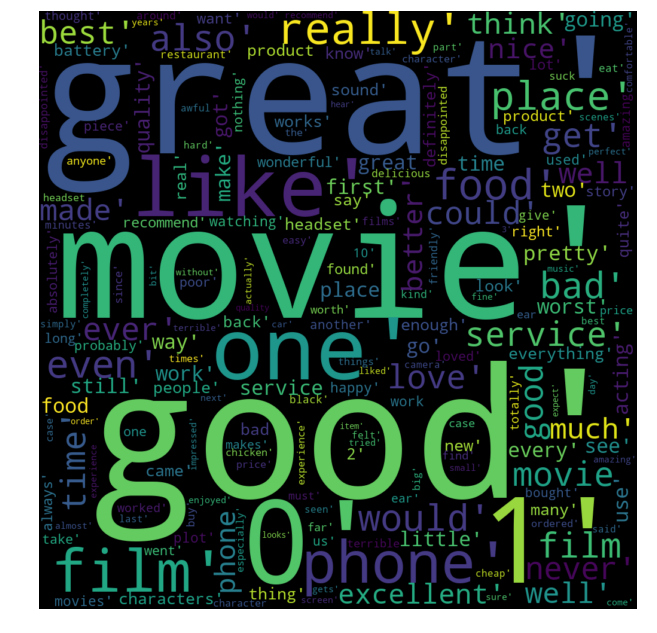

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopwordsNltk = stopwords.words('english')

from wordcloud import WordCloud

words = []

for senteca in df.sentence:
    for palavra in senteca.lower().split():
        if(palavra not in stopwordsNltk):
            words.append(palavra)
            
words = str(words)

wordcloud = WordCloud(width=1000, height=1000, margin=0).generate(words)
plt.figure(figsize=(20,11))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Antes de iniciarmos uma análise mais profunda e técnica, podemos procurar padrões “suspeitos” em nosso dataset</h1>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
<ul style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    <li>Será que existe diferença de tamanho (caracteres) do comentário entre os datasets?</li>
    <li>Podemos verificar alguma correlação tamanho do review x sentimento?</li>
    <li>A forma de escrita do comentário (exemplos: educado, rude, gírias, etc…) tem influência no sentimento <strong>positivo</strong> ou <strong>negativo</strong>?</li>
</ul>
</div>
<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
   Vamos descobrir através da vizualização dos dados 
    </p>
<div>


In [9]:
df['tamanho_texto'] = df['sentence'].apply(len)
df.head()

,sentence,label,fonte,tamanho_texto
1,So there is no way for me to plug it in here i...,0.0,amazon,82
2,"Good case, Excellent value.",1.0,amazon,27
5,Great for the jawbone.,1.0,amazon,22
10,Tied to charger for conversations lasting more...,0.0,amazon,79
11,The mic is great.,1.0,amazon,17


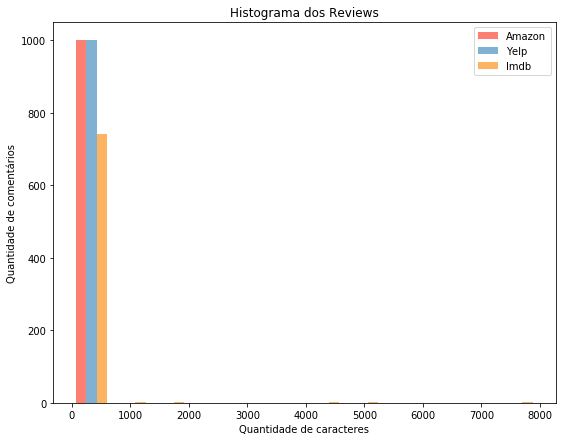

In [10]:
x1 = list(df[df['fonte'] == 'amazon']['tamanho_texto'])
x2 = list(df[df['fonte'] == 'yelp']['tamanho_texto'])
x3 = list(df[df['fonte'] == 'imdb']['tamanho_texto'])

colors = ['#fb8072', '#80b1d3', '#fdb462']
names = ['Amazon', 'Yelp', 'Imdb']

plt.figure(figsize=(9,7))
plt.hist([x1, x2, x3], bins = int(180/15), normed=False, color = colors, label=names)

plt.xlabel('Quantidade de caracteres')
plt.ylabel('Quantidade de comentários')
plt.title('Histograma dos Reviews')
plt.legend();

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    Verificando rapidamente o histograma acima, não parece haver distinção entre os Datasets, apenas o Imdb apresenta alguns comentários mais longos que os demais. Mas será que isso influencia no sentimento do comentário: Positivo ou Negativo?
    </p>
</div>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    Vamos verificar...
    </p>
</div>

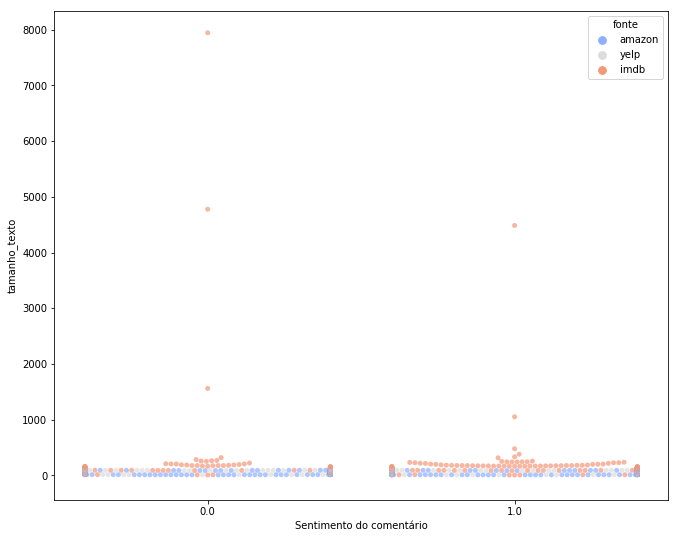

In [11]:
plt.figure(figsize=(11, 9))
sns.swarmplot(x='label', y='tamanho_texto', data=df, hue='fonte', alpha=0.7, palette='coolwarm')
plt.xlabel('Sentimento do comentário');

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    Conforme mostra nosso swarmplot, não há relação entre o tamanho do comentário com a probabilidade de ser Positivo ou Negativo.
    </p>
</div>

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Vamos começar efetivamente a análise de sentimento com dataset da Amazon!</h1>

<img src="./imgs/amazon.png"/>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
<ul style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    <li>A base de dados será dividida em 80/20, sendo respectivamente: Treino e Teste</li>
    <li>Utilizado Stemming — Refere-se a um processo heurístico não muito refinado que corta as extremidades das palavras na esperança de atingir esse objetivo corretamente na maior parte do tempo, e geralmente inclui a remoção de afixos derivados</li>
</ul>
</div>

In [12]:
amazon = df[df['fonte'] == 'amazon']
amazon = amazon[['sentence', 'label']]
print('Formato do Dataframe da Amazon {}'.format(amazon.shape))
amazon.head()

Formato do Dataframe da Amazon (1000, 2)


,sentence,label
1,So there is no way for me to plug it in here i...,0.0
2,"Good case, Excellent value.",1.0
5,Great for the jawbone.,1.0
10,Tied to charger for conversations lasting more...,0.0
11,The mic is great.,1.0


In [14]:
amazon['sentence'] = amazon['sentence'].str.replace('[^\w\s]','')
amazon.head()

,sentence,label
1,So there is no way for me to plug it in here i...,0.0
2,Good case Excellent value,1.0
5,Great for the jawbone,1.0
10,Tied to charger for conversations lasting more...,0.0
11,The mic is great,1.0


<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Divisão da base de dados</h1>

In [15]:
from sklearn.model_selection import train_test_split
treino, teste = train_test_split(amazon, test_size=0.2)

In [16]:
print('Shape dos dados de Treino {}'.format(treino.shape))
treino.label.value_counts(normalize=True)

Shape dos dados de Treino (800, 2)


1.0    0.51
0.0    0.49
Name: label, dtype: float64

In [17]:
print('Shape dos dados de Teste {}'.format(teste.shape))
teste.label.value_counts(normalize=True)

Shape dos dados de Teste (200, 2)


0.0    0.54
1.0    0.46
Name: label, dtype: float64

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Aplicando Stemmer</h1>

In [18]:
treino = [tuple(x) for x in treino.values]

In [19]:
def aplica_stemmer(texto):
    stemmer = nltk.stem.SnowballStemmer('english')
    
    frases_com_stemming = []
    for (palavras, sentimento) in texto:
        com_stemming = [str(stemmer.stem(p)) for p in palavras.lower().split() if p not in stopwordsNltk]
        frases_com_stemming.append((com_stemming, sentimento))
    return frases_com_stemming

In [20]:
frases_com_stem_treinamento = aplica_stemmer(treino)

In [21]:
pd.DataFrame(frases_com_stem_treinamento, columns=['frase', 'sentimento']).sample(10)

,frase,sentimento
572,[comfort],1.0
293,"[look, nice]",1.0
421,"[kind, embarrass, use, look, most, embarrass, ...",0.0
125,"[simpl, lightweight, great, fit]",1.0
28,"[verizon, bill, howev, difficult, understand, ...",0.0
102,"[great, case, price]",1.0
578,"[dont, wast, one]",0.0
467,"[internet, excruti, slow]",0.0
538,"[good, item, work, start, problem, auto, rever...",0.0
716,"[product, excel, work, better, verizon, one, b...",1.0


In [22]:
teste = [tuple(x) for x in teste.values]
frases_com_stem_teste = aplica_stemmer(teste)

In [23]:
def busca_palavras(frases):
    todas_palavras = []
    for (palavras, sentimento) in frases:
        todas_palavras.extend(palavras)
    return todas_palavras

In [24]:
palavras_treinamento = busca_palavras(frases_com_stem_treinamento)
palavras_teste = busca_palavras(frases_com_stem_teste)

In [28]:
print('Quantidade de palavras na base de treinamento {}'.format(pd.DataFrame(palavras_treinamento).count()))

Quantidade de palavras na base de treinamento 0    4253
dtype: int64


<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Listando palavras mais populares</h1>

In [27]:
def busca_frequencia(palavras):
    palavras = nltk.FreqDist(palavras)
    return palavras

In [28]:
frenquencia_treinamento = busca_frequencia(palavras_treinamento)
frenquencia_treinamento.most_common(10)

[('phone', 139),
 ('work', 83),
 ('great', 78),
 ('good', 66),
 ('use', 48),
 ('product', 46),
 ('qualiti', 45),
 ('headset', 43),
 ('sound', 43),
 ('batteri', 38)]

In [29]:
frenquencia_teste = busca_frequencia(palavras_teste)
frenquencia_teste.most_common(10)

[('phone', 34),
 ('work', 29),
 ('use', 23),
 ('great', 19),
 ('one', 15),
 ('headset', 12),
 ('ear', 12),
 ('get', 11),
 ('dont', 10),
 ('product', 10)]

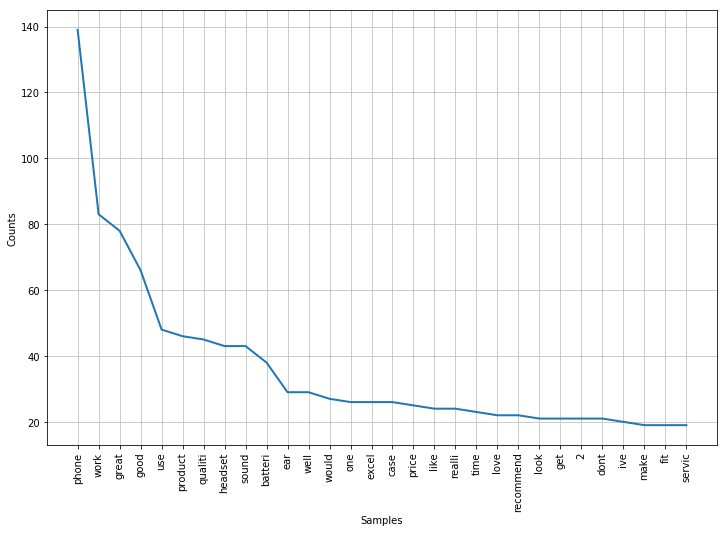

In [30]:
plt.figure(figsize=(12,8))
frenquencia_treinamento.plot(30, cumulative=False);

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Buscando palavras unicas</h1>

In [31]:
def busca_palavras_unicas(frequencia):
    freq = frequencia.keys()
    return freq

palavras_unicas_treinamento = busca_palavras_unicas(frenquencia_treinamento)
palavras_unicas_teste = busca_palavras_unicas(frenquencia_teste)

In [44]:
def extrator_palavras(documento):
    doc = set(documento) #coleção não ordenada e não indexada
    caracteristicas  = {}
    for palavras in palavras_unicas_treinamento:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [45]:
def extrator_palavras_teste(documento):
    doc = set(documento) #coleção não ordenada e não indexada
    caracteristicas  = {}
    for palavras in palavras_unicas_teste:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [46]:
base_completa_treinamento = nltk.classify.apply_features(extrator_palavras, frases_com_stem_treinamento)
base_completa_teste = nltk.classify.apply_features(extrator_palavras_teste, frases_com_stem_teste)

In [47]:
base_completa_treinamento

[({'awesom': True, 'devic': True, 'love': False, 'headset': False, 'reach': False, 'bottom': False, 'row': False, 'uncomfort': False, 'send': False, 'end': False, 'key': False, 'expect': False, 'be3': False, 'great': False, 'product': False, 'sure': False, 'beat': False, 'use': False, 'finger': False, 'bought': False, 'hope': False, 'could': False, 'make': False, 'bluetooth': False, 'fit': False, 'better': False, 'thing': False, 'made': False, 'imposs': False, 'wear': False, 'cheap': False, 'plastic': False, 'creak': False, 'like': False, 'old': False, 'wooden': False, 'floor': False, 'stay': False, 'away': False, 'q': False, 'look': False, 'feel': False, 'samsung': False, 'flipphon': False, 'span': False, 'hour': False, 'two': False, 'peopl': False, 'exclaim': False, 'whoa': False, 'new': False, 'phone': False, 'tv': False, 'yet': False, 'run': False, 'batteri': False, 'bar': False, 'that': False, 'three': False, 'day': False, 'without': False, 'charg': False, 'saggi': False, 'floppi'

In [53]:
classificador = nltk.NaiveBayesClassifier.train(base_completa_treinamento)
print(classificador.labels())

[1.0, 0.0]


In [54]:
print('Acurácia: {}%'.format(nltk.classify.accuracy(classificador, base_completa_teste)))

Acurácia: 0.795%


<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Como melhorar o modelo?</h1>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
<ul style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    <li>Aumentar a base de dados para o treino e teste, com isso teríamos um modelo mais robusto</li>
    <li>Testar outros algoritmos e hiperparâmetros</li>
    <li>Incluir novas StopWords…</li>
</ul>
</div>

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Verificando os erros do modelo</h1>

In [39]:
erros = []
for (frase, classe) in base_completa_teste:
    resultado = classificador.classify(frase)
    if resultado != classe:
        erros.append((classe, resultado, frase))

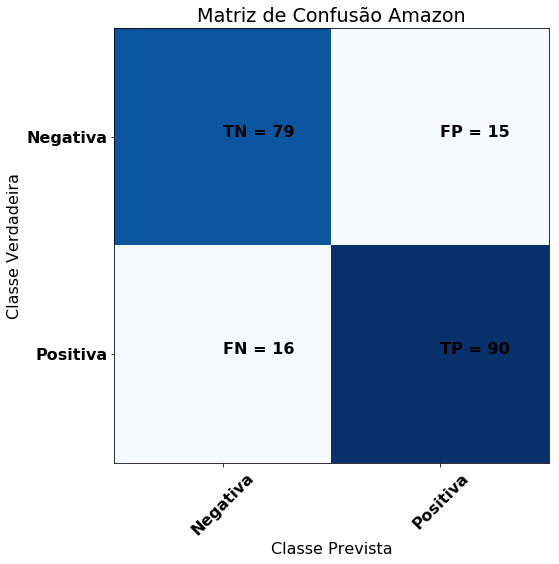

In [40]:
esperado = []
previsto = []
for (frase, classe) in base_completa_teste:
    resultado = classificador.classify(frase)
    previsto.append(resultado)
    esperado.append(classe)

    
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 16}    

plt.rc('font', **font)       
cm = confusion_matrix(esperado, previsto)
plt.figure(figsize=(12, 8))
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap='Blues')
className = ['Negativa','Positiva']
plt.title('Matriz de Confusão Amazon')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
tick_marks = np.arange(len(className))
plt.xticks(tick_marks, className, rotation=45)
plt.yticks(tick_marks, className);
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(s[i][j] + " = " + str(cm[i][j])))
plt.show();

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Usando o NLTK para análisar o Sentimento</h1>

In [78]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in amazon.sentence:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

print(results[:3])

[{'neg': 0.12, 'neu': 0.88, 'pos': 0.0, 'compound': -0.3535, 'headline': 'So there is no way for me to plug it in here in the US unless I go by a converter'}, {'neg': 0.0, 'neu': 0.1, 'pos': 0.9, 'compound': 0.8402, 'headline': 'Good case Excellent value'}, {'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249, 'headline': 'Great for the jawbone'}]


In [79]:
sentimentos = pd.DataFrame.from_records(results)
sentimentos.head()

,neg,neu,pos,compound,headline
0,0.120,0.880,0.000,-0.3535,So there is no way for me to plug it in here i...
1,0.000,0.100,0.900,0.8402,Good case Excellent value
2,0.000,0.423,0.577,0.6249,Great for the jawbone
3,0.256,0.744,0.000,-0.5319,Tied to charger for conversations lasting more...
4,0.000,0.423,0.577,0.6249,The mic is great


In [80]:
sentimentos['label'] = 0
sentimentos.loc[sentimentos['compound'] > 0.2, 'label'] = 1
sentimentos.loc[sentimentos['compound'] < -0.2, 'label'] = -1
sentimentos.head()

,neg,neu,pos,compound,headline,label
0,0.120,0.880,0.000,-0.3535,So there is no way for me to plug it in here i...,-1
1,0.000,0.100,0.900,0.8402,Good case Excellent value,1
2,0.000,0.423,0.577,0.6249,Great for the jawbone,1
3,0.256,0.744,0.000,-0.5319,Tied to charger for conversations lasting more...,-1
4,0.000,0.423,0.577,0.6249,The mic is great,1


In [118]:
amazon.index = range(len(amazon))

In [123]:
accuracy_score(amazon.label, sentimentos.label)

0.587

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Probabilidade de cada classe</h1>

In [56]:
teste = 'i love the movie'
testeStemming = []
stemmer = nltk.stem.SnowballStemmer('english')

for (palavras_treinamento) in teste.split():
    comStem = [p for p in palavras_treinamento.split()]
    testeStemming.append(str(stemmer.stem(comStem[0])))
    
novo = extrator_palavras(testeStemming)
distribuicao = classificador.prob_classify(novo)

for classe in distribuicao.samples():
    print('%s: %f' % (classe, distribuicao.prob(classe)))
    if classe == 0:
        print('Probalidade de ser Negativa')
    else:
        print('Probalidade de ser Positiva')
        

1.0: 0.982389
Probalidade de ser Positiva
0.0: 0.017611
Probalidade de ser Negativa


<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Agora vamos realizar a análise de sentimentos da Yelp</h1>

<img style="width: 500px]; heigth: 500px" src="./imgs/yelp.png"/>

In [42]:
yelp = df[df['fonte'] == 'yelp']
yelp = yelp[['sentence', 'label']]
print('Formato do Dataframe da Yelp {}'.format(yelp.shape))
yelp.head()

Formato do Dataframe da Yelp (1000, 2)


,sentence,label
0,Wow... Loved this place.,1.0
3,Crust is not good.,0.0
4,Not tasty and the texture was just nasty.,0.0
10,Stopped by during the late May bank holiday of...,1.0
11,The selection on the menu was great and so wer...,1.0


In [43]:
#criando uma coluna com os índices

yelp['index'] = yelp.index
yelp.head()

,sentence,label,index
0,Wow... Loved this place.,1.0,0
3,Crust is not good.,0.0,3
4,Not tasty and the texture was just nasty.,0.0,4
10,Stopped by during the late May bank holiday of...,1.0,10
11,The selection on the menu was great and so wer...,1.0,11


In [44]:
# Tratando os comentarios para tamanho minúsculo e removendo caracteres especiais e pontuações

yelp.columns = ['Sentence', 'Class', 'index']
yelp['Sentence'] = yelp['Sentence'].str.lower()

yelp['Sentece'] = yelp['Sentence'].str.replace('[^w\s]','')

#Também iremos remover  os numeros

yelp['Sentence'] = yelp['Sentence'].replace('\d', '', regex=True)
df_ = pd.DataFrame(columns=yelp.columns)

In [45]:
#remove stop words

for index, row in yelp.iterrows():
    word_tokens = word_tokenize(row['Sentence'])
    frase_filtrada = [p for p in word_tokens if not p in stopwords.words('english')]
    df_ = df_.append({"index": row['index'], "Class": row['Class'], "Sentence": " ".join(
    frase_filtrada[0:])}, ignore_index=True)

In [46]:
yelp = df_

# A divisão da base de Treino e teste também será de 80/20

X_train, X_test, y_train, y_test = train_test_split(yelp['Sentence'].values.astype('U'),
                                                   yelp['Class'].values.astype('int32'),
                                                   test_size=0.20, random_state=42)

In [47]:
classes = yelp['Class'].unique()
classes

array([1., 0.])

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Utilizando TF-IDF</h1>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
No caso do TFIDF, o único pré-processamento de texto é remover a pontuação e diminuir as letras maiúsculas e minúsculas. Nós não temos que nos preocupar com as StopWords. O TFIDF é a junção do TF e IDF.
    </p>
</div>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
<ul style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
    <li>O TFIDF é usado com sucesso pelos mecanismos de pesquisa, como o Google, como um fator de classificação para o conteúdo.</li>
    <li>A ideia é pesar os termos freqüentes e aumentar os mais raros</li>
</ul>
</div>

In [48]:
vectorizer = TfidfVectorizer()
counts = vectorizer.fit_transform(X_train)

In [49]:
vocab = vectorizer.vocabulary_
classifier = SGDClassifier(penalty='elasticnet', random_state=42)
targets = y_train
classifier = classifier.fit(counts, targets)
example_counts = vectorizer.transform(X_test)
previsoes = classifier.predict(example_counts)

In [50]:
print(accuracy_score(y_test, previsoes))

0.755


<div style='padding:20px; border: 1px solid #FFDAB9; border-radius: 5px; background: #FFDAB9'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
Nossa acurácia para este modelo foi de 77,5% utilizando SGDClassifier.
    </p>
</div>    

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Matriz de Confusão</h1>

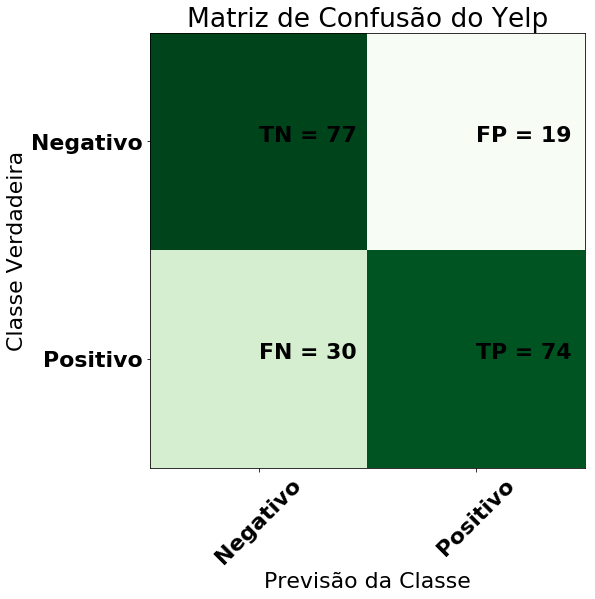

In [51]:
# Caracteristicas das fontes

font = {
    'family' : 'normal',
    'weight' : 'bold',
    'size' : 22}

plt.rc('font', **font)

cm = confusion_matrix(y_test, previsoes)
plt.figure(figsize=(12,8))
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap='Greens')
classNames = ['Negativo','Positivo']
plt.title('Matriz de Confusão do Yelp')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Previsão da Classe')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN','TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+' = ' + str(cm[i][j]))

plt.show()



<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Agora vamos analisar o Imdb</h1>

<div style='padding:20px; border: 1px solid #FFFACD; border-radius: 5px; background: #FFFACD'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
        <strong>Obs:</strong> Nós poderíamos realizar uma única análise de sentimentos com o dataset consolidade que foi importado (concatenação) de todos os conjuntos, porém, o notebook ficará mais completo e didático se tratarmos de forma separada...<br><br> 
        Mãos a obra!
    </p>
</div> 

<img style="width=500px; height: 500px" src="./imgs/imdb.png"/>

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Separando os Dados</h1>

In [59]:
imdb = df[df['fonte'] == 'imdb']
imdb = imdb[['sentence', 'label']]
print('Formato do DataFrame do Imdb {}'.format(imdb.shape))
imdb.head()

Formato do DataFrame do Imdb (748, 2)


,sentence,label
0,"A very, very, very slow-moving, aimless movie ...",0.0
1,Not sure who was more lost - the flat characte...,0.0
2,Attempting artiness with black & white and cle...,0.0
3,Very little music or anything to speak of.,0.0
4,The best scene in the movie was when Gerardo i...,1.0


<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Removendo StopWords</h1>

In [60]:
#Criamos uma nova coluna e utilizamos a instancia do StopWords criada durante o tratamento da Amazon
imdb['sentence'] = imdb['sentence'].map(lambda x: x.lower())
imdb['sentence_sem_stop'] = imdb['sentence'].apply(lambda x: ' '.join(p for p in x.split() if p not in
                                                                     stopwordsNltk))
imdb.head()

,sentence,label,sentence_sem_stop
0,"a very, very, very slow-moving, aimless movie ...",0.0,"very, very, slow-moving, aimless movie distres..."
1,not sure who was more lost - the flat characte...,0.0,"sure lost - flat characters audience, nearly h..."
2,attempting artiness with black & white and cle...,0.0,attempting artiness black & white clever camer...
3,very little music or anything to speak of.,0.0,little music anything speak of.
4,the best scene in the movie was when gerardo i...,1.0,best scene movie gerardo trying find song keep...


<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Análise Morfológica
</h1>

In [61]:
def num_pos(frase_sem_stop):
    return TextBlob(frase_sem_stop).tags

In [62]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hermino/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [63]:
sub_a = imdb['sentence_sem_stop'].apply(num_pos)
df_1 = pd.DataFrame(sub_a)

In [64]:
# Criando a nova coluna, cada linha em uma string,
# Onde cada palavra será unida com a sua pos correpondene e um único espaço irá separar as palavras.

df_1['col_pos'] = df_1['sentence_sem_stop'].map(lambda x:" ".join(["/".join(x) for x in x]))

In [65]:
imdb = pd.merge(imdb, df_1, left_index = True, right_index = True,)
imdb.head()

,sentence,label,sentence_sem_stop_x,sentence_sem_stop_y,col_pos
0,"a very, very, very slow-moving, aimless movie ...",0.0,"very, very, slow-moving, aimless movie distres...","[(very, RB), (very, RB), (slow-moving, NN), (a...",very/RB very/RB slow-moving/NN aimless/JJ movi...
1,not sure who was more lost - the flat characte...,0.0,"sure lost - flat characters audience, nearly h...","[(sure, NN), (lost, VBN), (flat, JJ), (charact...",sure/NN lost/VBN flat/JJ characters/NNS audien...
2,attempting artiness with black & white and cle...,0.0,attempting artiness black & white clever camer...,"[(attempting, VBG), (artiness, JJ), (black, JJ...",attempting/VBG artiness/JJ black/JJ &/CC white...
3,very little music or anything to speak of.,0.0,little music anything speak of.,"[(little, JJ), (music, NN), (anything, NN), (s...",little/JJ music/NN anything/NN speak/NN of/IN
4,the best scene in the movie was when gerardo i...,1.0,best scene movie gerardo trying find song keep...,"[(best, JJS), (scene, NN), (movie, NN), (gerar...",best/JJS scene/NN movie/NN gerardo/NN trying/V...


<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
Site que explica cada sigla: https://www.clips.uantwerpen.be/pages/pattern-en
    </p>
</div>

<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Classificação e Ajuste de Hiperparâmetros
</h1>

In [66]:
X_train, X_test, y_train, y_test = train_test_split(imdb['col_pos'],
                                                   imdb['label'],
                                                   test_size=0.20, random_state=42)

In [67]:
Tfidf = TfidfVectorizer(smooth_idf= True, lowercase= True, sublinear_tf=False, use_idf=True)

X_train_Tfidf = Tfidf.fit_transform(X_train)
X_test_Tfidf = Tfidf.transform(X_test)

In [68]:
def selecao_params(X,y,nfolds):
    Cs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X,y)
    return grid_search.best_params_

In [69]:
# Deixamos o K folds com 5 partições

selecao_params(X_train_Tfidf, y_train, 5)

{'C': 1}

<div style='padding:20px; border: 1px solid #FFFACD; border-radius: 5px; background: #FFFACD'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
        Como o melhor C encontrado pelo GridSearch foi o C = 1, não precisamos deixar explícito pois o default é este valor.
    </p>
</div> 

In [70]:
clf = SVC(kernel='linear', C=1)
clf.fit(X_train_Tfidf, y_train)
previsao = clf.predict(X_test_Tfidf)

In [71]:
print(accuracy_score(y_test,previsao))

0.7733333333333333


<h1 style='font-family:ubuntu; color:#1C1C1C; font-size:25px'>Terminamos nossa análise de sentimentos para os 3 Datasets</h1>

<div style='padding:20px; border: 1px solid #E0FFFF; border-radius: 5px; background: #E0FFFF'>
    <p style='font-family:Ubuntu Mono; color:#1C1C1C; font-size:18px'>
Para fechar, vamos realizar a análise de sentimentos com um único Dataset, 
    sem diferenciar a fonte dos dados.
    </p>
</div>

In [65]:
df = df[['sentence', 'label']]
df['index'] = df.index
df.head()

,sentence,label,index
1,So there is no way for me to plug it in here i...,0.0,1
2,"Good case, Excellent value.",1.0,2
5,Great for the jawbone.,1.0,5
10,Tied to charger for conversations lasting more...,0.0,10
11,The mic is great.,1.0,11


In [66]:
df.columns = ['Sentence', 'Class', 'index']
df['Sentence'] = df['Sentence'].str.lower()

df['Sentece'] = df['Sentence'].str.replace('[^w\s]','')

#Também iremos remover  os numeros

df['Sentence'] = df['Sentence'].replace('\d', '', regex=True)
df_ = pd.DataFrame(columns=df.columns)

In [67]:
for index, row in df.iterrows():
    word_tokens = word_tokenize(row['Sentence'])
    frase_filtrada = [p for p in word_tokens if not p in stopwords.words('english')]
    df_ = df_.append({"index": row['index'], "Class": row['Class'], "Sentence": " ".join(
    frase_filtrada[0:])}, ignore_index=True)

In [68]:
df = df_

# A divisão da base de Treino e teste também será de 80/20

X_train, X_test, y_train, y_test = train_test_split(df['Sentence'].values.astype('U'),
                                                   df['Class'].values.astype('int32'),
                                                   test_size=0.20, random_state=42)

In [69]:
classes = df['Class'].unique()
classes

array([0., 1.])

In [70]:
vectorizer = TfidfVectorizer()
counts = vectorizer.fit_transform(X_train)
vocab = vectorizer.vocabulary_
classifier = SGDClassifier(penalty='elasticnet', random_state=42)
targets = y_train
classifier = classifier.fit(counts, targets)
example_counts = vectorizer.transform(X_test)
previsoes = classifier.predict(example_counts)

In [71]:
print(accuracy_score(y_test, previsoes))

0.7818181818181819


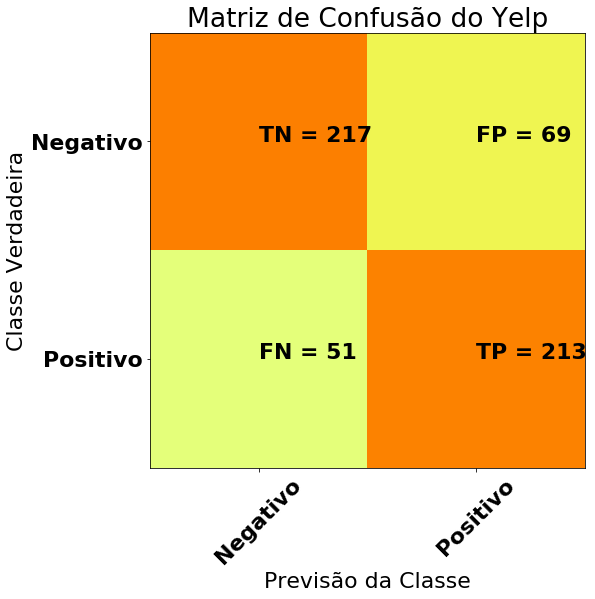

In [72]:
# Caracteristicas das fotes

font = {
    'family' : 'normal',
    'weight' : 'bold',
    'size' : 22}

plt.rc('font', **font)

cm = confusion_matrix(y_test, previsoes)
plt.figure(figsize=(12,8))
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negativo','Positivo']
plt.title('Matriz de Confusão do Yelp')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Previsão da Classe')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN','TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+' = ' + str(cm[i][j]))

plt.show()